In [6]:
import numpy as np

import sys
sys.path.append("..")
from nc_suite import *

In [7]:
# Create img and labels
from torchvision import datasets
import cv2

img_baby = cv2.imread("../data/test/3.jpg",0)
img_baby = cv2.resize(img_baby, (20,20))

mnist = datasets.MNIST('data', train=True, download=True)
img = np.asarray(mnist[2][0])

labels = np.copy(img) # shallow copy is fine, since it isn't python objects inside
labels[labels>0] = 1

In [8]:
# Really simple weighting methods...
from sklearn import feature_extraction

sk_W = feature_extraction.image.img_to_graph(img, return_as=np.ndarray) # adjaceny matrix
i_W = intensity_weight_matrix(img)
p_W = positional_weight_matrix(img)
pi_W = intens_posit_wm(img)
man_bin_W_1 = manual_weights_binary(img, r=1)
man_abs_W_1 = manual_weights_abs(img, r=1)
man_bin_W_10 = manual_weights_binary(img, r=10)
man_abs_W_10 = manual_weights_abs(img, r=10)

sk_W_baby = feature_extraction.image.img_to_graph(img_baby, return_as=np.ndarray)
i_W_baby = intensity_weight_matrix(img_baby)
p_W_baby = positional_weight_matrix(img_baby)
pi_W_baby = intens_posit_wm(img_baby)
man_bin_W_baby_1 = manual_weights_binary(img_baby, r=1)
man_abs_W_baby_1 = manual_weights_abs(img_baby, r=1)
man_bin_W_baby_10 = manual_weights_binary(img_baby, r=10)
man_abs_W_baby_10 = manual_weights_abs(img_baby, r=10)

# TODO: https://github.com/avnCode/Image_Segmentation/blob/main/nCut.ipynb
# tests similar to

/mnt/c/Users/garth/Desktop/DDN/notebooks/../nc_suite.py:35: RuntimeWarning: overflow encountered in ubyte_scalars
  W[u][v] = W[u][v] = np.abs(I[u] - I[v]) # Symmetric


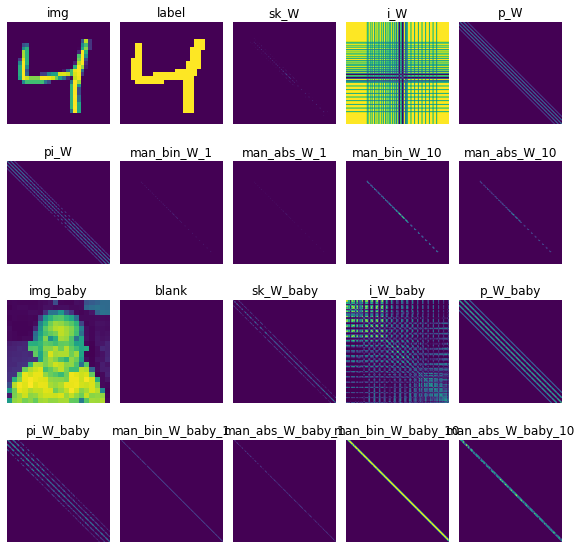

In [11]:
plt.rcParams["figure.figsize"] = (8,8) # specify the size for this cell
plot_images([img, labels, sk_W, i_W, p_W, pi_W, man_bin_W_1, man_abs_W_1, man_bin_W_10, man_abs_W_10,
             img_baby, np.zeros_like(img_baby), sk_W_baby, i_W_baby, p_W_baby, pi_W_baby, man_bin_W_baby_1, man_abs_W_baby_1, man_bin_W_baby_10, man_abs_W_baby_10], 
            
            ['img', 'label', 'sk_W', 'i_W', 'p_W', 'pi_W', 'man_bin_W_1', 'man_abs_W_1', 'man_bin_W_10', 'man_abs_W_10',
             'img_baby', 'blank', 'sk_W_baby', 'i_W_baby', 'p_W_baby', 'pi_W_baby', 'man_bin_W_baby_1', 'man_abs_W_baby_1', 'man_bin_W_baby_10', 'man_abs_W_baby_10'])

In [ ]:
from scipy.sparse.linalg import eigsh

def solve_here(W):
    # Diagonal Matrix - D
    d = np.sum(W, axis=1)
    D = np.zeros_like(W)
    np.fill_diagonal(D, np.sum(W, axis=1))

    A = D - W
    _, eig_vector = eigsh(A, k=2, which='SA')
    op_image = eig_vector[:, 1].reshape(img.shape[0], img.shape[1])

    return op_image

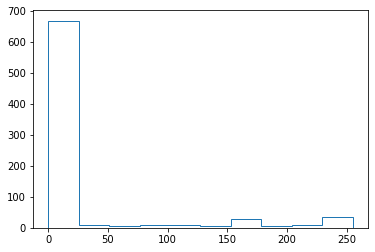

[669  10   7   9   8   5  27   5   8  36]
[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]


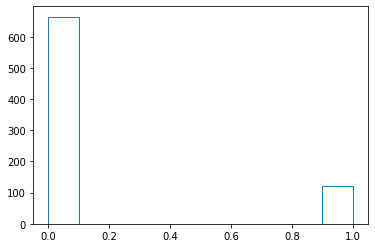

[664   0   0   0   0   0   0   0   0 120]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [10]:
counts, bins = np.histogram(img)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)

counts, bins = np.histogram(labels)
plt.stairs(counts,bins)
plt.show()
print(counts)
print(bins)